<a href="https://colab.research.google.com/github/HHHMGK/VTinyLM/blob/main/%5BTHESIS%5D_phoGPT_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq einops
!pip install -qq datasets
!pip install -qq --upgrade --force-reinstall transformers==4.42
!pip install -qq --upgrade pandas pandasai


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.1.21 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.4.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.4.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fss

In [ ]:
!pip list | grep -e transformers -e numpy -e pandas

geopandas                          1.0.1
numpy                              1.26.4
pandas                             1.5.3
pandas-datareader                  0.10.0
pandas-gbq                         0.28.0
pandas-stubs                       2.2.2.240909
pandasai                           2.4.2
sentence-transformers              3.4.1
sklearn-pandas                     2.2.0
transformers                       4.42.0


In [ ]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import gc

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [ ]:
model_path = "vinai/PhoGPT-4B-Chat"

config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
config.init_device = device
# config.attn_config['attn_impl'] = 'flash' # If installed: this will use either Flash Attention V1 or V2 depending on what is installed

# model = AutoModelForCausalLM.from_pretrained(model_path, config=config, torch_dtype=torch.bfloat16, trust_remote_code=True)
# If your GPU does not support bfloat16:
model = AutoModelForCausalLM.from_pretrained(model_path, config=config, torch_dtype=torch.float16, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

/root/.cache/huggingface/modules/transformers_modules/vinai/PhoGPT-4B-Chat/3b11fad96d853b78f2fecc76f13aedb381b02d5a/configuration_mpt.py:114: UserWarning: alibi or rope is turned on, setting `learned_pos_emb` to `False.`
  warnings.warn(f'alibi or rope is turned on, setting `learned_pos_emb` to `False.`')
/root/.cache/huggingface/modules/transformers_modules/vinai/PhoGPT-4B-Chat/3b11fad96d853b78f2fecc76f13aedb381b02d5a/configuration_mpt.py:141: UserWarning: If not using a Prefix Language Model, we recommend setting "attn_impl" to "flash" instead of "triton".
  warnings.warn(UserWarning('If not using a Prefix Language Model, we recommend setting "attn_impl" to "flash" instead of "triton".'))


In [ ]:
from datasets import load_dataset, Dataset
import random

def get_examples(dataset, tokenizer, n_samples, seq_len = 128, rand=True, custom_ds=None, ds_file=None):
    if dataset == 'c4':
        traindata = load_dataset(
            'allenai/c4', data_files='en/c4-train.00000-of-01024.json.gz',split='train'
        )
    elif dataset == 'bookcorpus':
        traindata = load_dataset(
            'bookcorpus', split='train'
        )
    # elif custom_ds is None:
    #     raise Exception('Invalid dataset')
    elif dataset == 'oscar-vi':
        # 'https://huggingface.co/datasets/oscar-corpus/OSCAR-2301/blob/main/vi_meta/vi_meta_part_1.jsonl.zst'
        traindata = load_dataset(
            'oscar-corpus/OSCAR-2301', language='vi', split='train',streaming=True
        )
        data_list=[]
        for d in traindata:
            data_list.append(d)
            if len(data_list) == n_samples:
                break
        # data_list = list(traindata["train"].take(n_samples*10))
        traindata = Dataset.from_list(data_list)

    tokenized_samples, history = [], []
    if rand:
        for _ in range(n_samples):
            while True:
                i = random.randint(0, len(traindata) - 1)
                if i in history:
                    continue
                tokenized_sample = tokenizer(traindata[i]['text'], return_tensors='pt')
                if tokenized_sample.input_ids.shape[1] >= seq_len:
                    history.append(i)
                    break
            i = random.randint(0, tokenized_sample.input_ids.shape[1] - seq_len)
            tokenized_samples.append(tokenized_sample.input_ids[:, i:i+seq_len])
    else:
        i = 0
        for _ in range(n_samples):
            while True:
                tokenized_sample = tokenizer(traindata[i]['text'], return_tensors='pt')
                if tokenized_sample.input_ids.shape[1] >= seq_len:
                    tokenized_samples.append(tokenized_sample.input_ids[:, :seq_len])
                    break
                i += 1
    return torch.cat(tokenized_samples, dim=0 )

In [ ]:
def ranking_by_grads(model, batch_input, avg=False, T_order=1, loss_accum_step=0):
    model.eval()
    model.zero_grad(set_to_none=True)

    batch_size = batch_input.shape[0]
    accum_steps = loss_accum_step if loss_accum_step > 0 else batch_size

    importance_list = [0.0] * len(model.transformer.blocks)

    for i in range(0, batch_size, accum_steps):
        # print('doing batch', i,i+accum_steps)
        input = batch_input[i:i+accum_steps]  # Process a smaller batch

        loss = model(input, labels=input).loss
        loss = loss / accum_steps  # Normalize the loss
        loss.backward()
        for id, layer in enumerate(model.transformer.blocks):
            importance = 0
            for name, param in layer.named_parameters():
                if param.requires_grad and param.grad is not None:
                    grad = param.grad
                    # for each weight, multiply it by the gradient for first-order
                    layer_importance = (grad * param).abs().sum().item()
                    if T_order >= 2:
                        # second order
                        # !!! not correct for now
                        layer_importance += -1.0/2 * layer_importance * layer_importance
                    if avg:
                        layer_importance /= param.numel()
                    importance += layer_importance
            importance_list[id] += importance

        model.zero_grad(set_to_none=True)
        gc.collect()
        torch.cuda.empty_cache()
    return importance_list

In [ ]:
def ranking_by_magnitude(model, norm='l1', avg=False, prefix=None):
    importance_list = []
    for id, layer in enumerate(model.transformer.blocks):
        layer_importance = 0.0
        for name, param in layer.named_parameters():
            if(prefix is not None and prefix not in name):
                continue
            if(norm == 'l1'):
                imp = param.detach().abs().sum(dtype=torch.float32).item()
            elif(norm == 'l2'):
                imp = param.detach().pow(2).sum(dtype=torch.float32).sqrt().item()
            if avg:
                imp /= param.numel()
            layer_importance += imp
        # print('-=-=-=-=-=-=-=-=-=- layer ',id,': ',layer_importance)
        importance_list.append(layer_importance)
    return importance_list

In [ ]:
hooks = []
# for hook in hooks:
#     hook.remove()

def rank_by_activation(model, batch_input, avg=False):
    model.eval()
    # importance_list = [0.0] * len(model.transformer.blocks)
    activations = {}
    sample_output = None
    def get_activation(name):
        def hook(module, input, output):
            if output is not None:
                sample_output = output
            act_val = output[0].detach().abs().mean().item()
            if name in activations:
                activations[name].append(act_val)
            else:
                activations[name] = [act_val]
        return hook

    for i, layer in enumerate(model.transformer.blocks):
        hook = layer.register_forward_hook(get_activation(f"layer_{i}"))
        hooks.append(hook)

    with torch.no_grad():
        model(batch_input)
    for hook in hooks:
        hook.remove()

    importance_list = []
    prev = 0
    for i in range(len(model.transformer.blocks)):
        acts = activations.get(f"layer_{i}", [0])
        layer_importance = sum(acts)
        if avg:
            layer_importance /= len(acts)
        importance_list.append(layer_importance - prev)
        prev = layer_importance

    print(sample_output)
    for k,v in activations.items():
        print(k,v)
    return importance_list


In [ ]:
# data = get_examples('bookcorpus', tokenizer, 10, seq_len = 64).to('cuda')
c4_data = get_examples('c4', tokenizer, 100, seq_len = 64).to(device)
vi_data = get_examples('oscar-vi', tokenizer, 1000, seq_len=64,rand=False).to(device)
# 'https://huggingface.co/datasets/oscar-corpus/OSCAR-2301/blob/main/vi_meta/vi_meta_part_1.jsonl.zst'

In [ ]:
print(vi_data.shape)
data_vi = vi_data[:100]
print(data_vi.shape)

torch.Size([1000, 64])
torch.Size([100, 64])


In [ ]:
print(c4_data.shape)
data_c4 = c4_data[:20]
print(data_c4.shape)

torch.Size([100, 64])
torch.Size([20, 64])


In [ ]:
def plotting_layers(ranks, num_layer=32, log=False, method_name=''):
    if log:
        ranks = np.log(ranks)
    x = range(32)
    y = ranks
    plt.plot(x,y)
    plt.xlabel('Layer')
    # plt.xticks(range(1,32,2))
    plt.ylabel('Importance' + (' (log scale)' if log else ''))
    plt.title('Importance of each layer ' + method_name)
    plt.show()

In [ ]:
# ranks = ranking_by_grads(model, data, avg=False, T_order=1, loss_accum_step=0)
# plotting_layers(ranks, log=False, method_name='grad T1 full batch')
# ranks = ranking_by_grads(model, data, avg=True, T_order=1, loss_accum_step=0)
# plotting_layers(ranks, log=True, method_name='grad AVG T1 full batch')
# ranks = ranking_by_grads(model, data, avg=False, T_order=2, loss_accum_step=0)
# plotting_layers(ranks, log=False, method_name='grad T2 full batch')
# ranks = ranking_by_grads(model, data, avg=True, T_order=2, loss_accum_step=0)
# plotting_layers(ranks, log=True, method_name='grad AVG T2 full batch')
# ranks = ranking_by_grads(model, data_c4, avg=False, T_order=1, loss_accum_step=0)
# plotting_layers(ranks, log=True, method_name='grad T1 full batch')
data_vi = vi_data[:20]
ranks = ranking_by_grads(model, data_vi, avg=False, T_order=1, loss_accum_step=0)
plotting_layers(ranks, log=True, method_name='grad T1 full batch')
ranks = ranking_by_grads(model, data_vi, avg=False, T_order=1, loss_accum_step=10)
plotting_layers(ranks, log=True, method_name='grad T1 full batch')
data_vi = vi_data[:100]
ranks = ranking_by_grads(model, data_vi, avg=False, T_order=1, loss_accum_step=10)
plotting_layers(ranks, log=True, method_name='grad T1 full batch')
ranks = ranking_by_grads(model, data_vi, avg=False, T_order=1, loss_accum_step=20)
plotting_layers(ranks, log=True, method_name='grad T1 full batch')
# ranks = ranking_by_grads(model, data_c4, avg=True, T_order=1, loss_accum_step=0)
# plotting_layers(ranks, log=True, method_name='grad AVG T1 full batch')
# ranks = ranking_by_grads(model, data_vi, avg=True, T_order=1, loss_accum_step=0)
# plotting_layers(ranks, log=True, method_name='grad AVG T1 full batch')

OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 26.12 MiB is free. Process 247689 has 14.71 GiB memory in use. Of the allocated memory 14.35 GiB is allocated by PyTorch, and 231.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

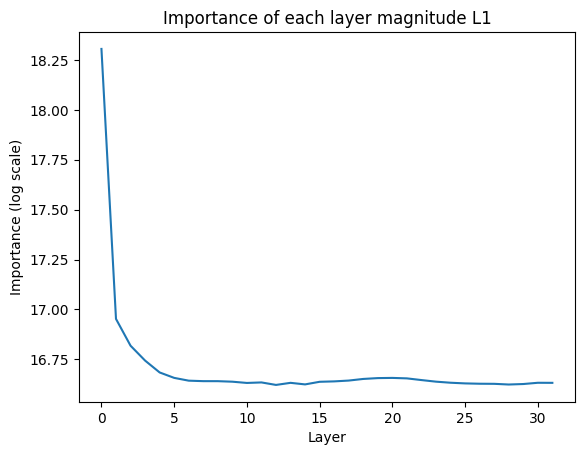

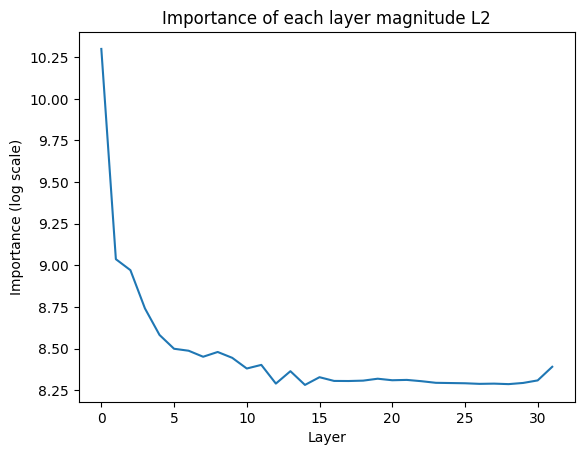

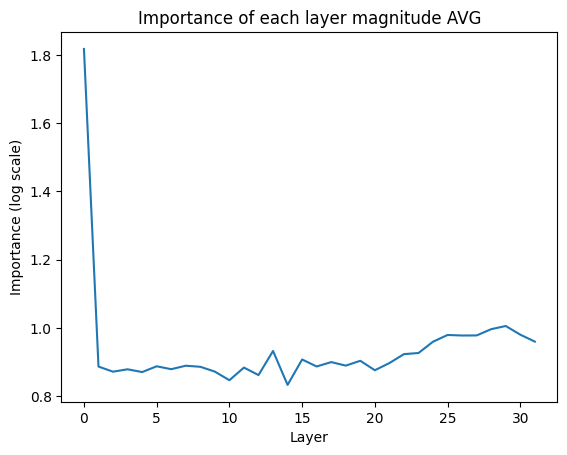

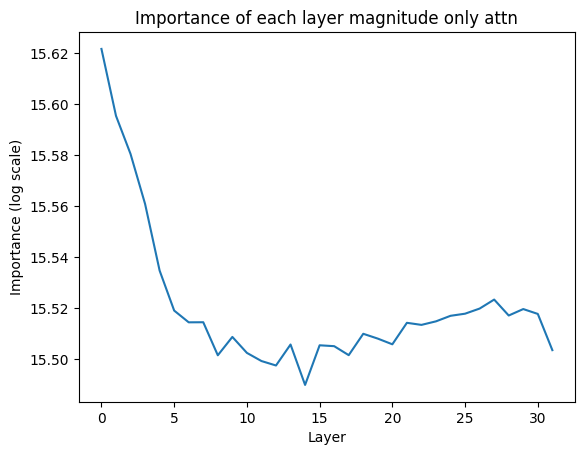

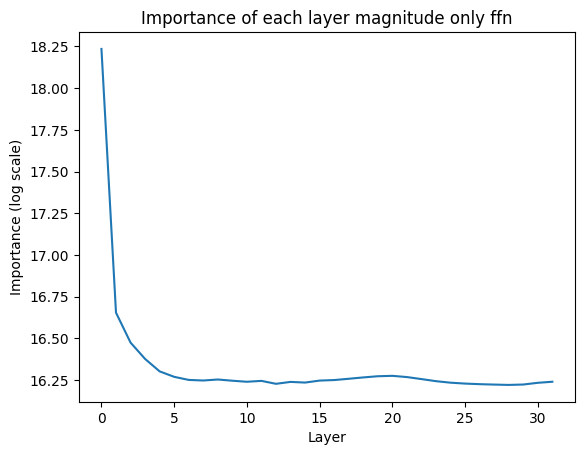

In [ ]:
ranks = ranking_by_magnitude(model, avg=False, prefix=None)
plotting_layers(ranks, log=True, method_name='magnitude L1')
ranks = ranking_by_magnitude(model, norm='l2', avg=False, prefix=None)
plotting_layers(ranks, log=True, method_name='magnitude L2')
ranks = ranking_by_magnitude(model, avg=True, prefix=None)
plotting_layers(ranks, log=True, method_name='magnitude AVG')
ranks = ranking_by_magnitude(model, avg=False, prefix='attn')
plotting_layers(ranks, log=True, method_name='magnitude only attn')
ranks = ranking_by_magnitude(model, avg=False, prefix='ffn')
plotting_layers(ranks, log=True, method_name='magnitude only ffn')

None
layer_0 [3.984375]
layer_1 [4.8359375]
layer_2 [5.78515625]
layer_3 [6.65625]
layer_4 [7.54296875]
layer_5 [8.34375]
layer_6 [9.3046875]
layer_7 [10.3359375]
layer_8 [11.3046875]
layer_9 [12.4375]
layer_10 [13.5390625]
layer_11 [14.859375]
layer_12 [15.9296875]
layer_13 [17.46875]
layer_14 [18.484375]
layer_15 [20.1875]
layer_16 [21.421875]
layer_17 [22.875]
layer_18 [24.609375]
layer_19 [26.390625]
layer_20 [28.34375]
layer_21 [30.921875]
layer_22 [33.4375]
layer_23 [36.21875]
layer_24 [38.9375]
layer_25 [41.84375]
layer_26 [43.875]
layer_27 [45.4375]
layer_28 [46.9375]
layer_29 [48.53125]
layer_30 [50.84375]
layer_31 [67.25]


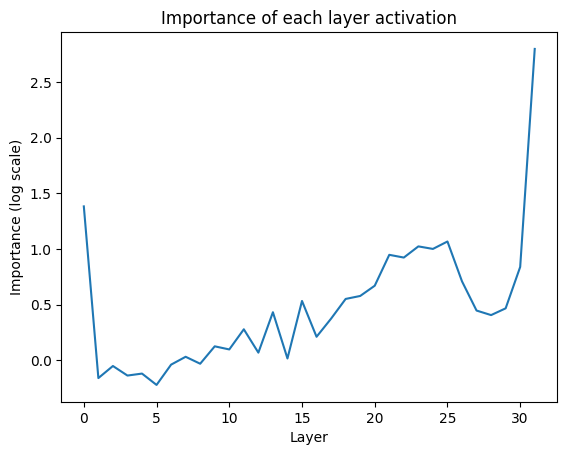

None
layer_0 [3.984375]
layer_1 [4.8359375]
layer_2 [5.78515625]
layer_3 [6.65625]
layer_4 [7.54296875]
layer_5 [8.34375]
layer_6 [9.3046875]
layer_7 [10.3359375]
layer_8 [11.3046875]
layer_9 [12.4375]
layer_10 [13.5390625]
layer_11 [14.859375]
layer_12 [15.9296875]
layer_13 [17.46875]
layer_14 [18.484375]
layer_15 [20.1875]
layer_16 [21.421875]
layer_17 [22.875]
layer_18 [24.609375]
layer_19 [26.390625]
layer_20 [28.34375]
layer_21 [30.921875]
layer_22 [33.4375]
layer_23 [36.21875]
layer_24 [38.9375]
layer_25 [41.84375]
layer_26 [43.875]
layer_27 [45.4375]
layer_28 [46.9375]
layer_29 [48.53125]
layer_30 [50.84375]
layer_31 [67.25]


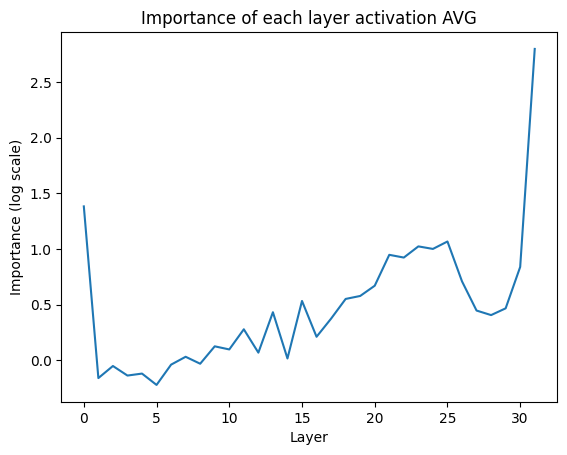

In [ ]:
ranks = rank_by_activation(model, data_vi, avg=False)
plotting_layers(ranks, log=True, method_name='activation')
ranks = rank_by_activation(model, data_vi, avg=True)
plotting_layers(ranks, log=True, method_name='activation AVG')

In [ ]:
# One layer testing

bl1 = model.transformer.blocks

In [ ]:
for name, par in bl1.named_parameters():
    print(name, par.numel())

In [ ]:
# del model
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
